# Dikemodel continued - subspace partitioning

Scenario discovery.... (nog uitleg toevoegen)

## 1. Apply scenario discovery

**1.** Import model from Open Exploration

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [54]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation2 import get_model_for_problem_formulation, sum_over, sum_over_time

**2.** Import results from Open Exploration

bla bla importeren en levers weghalen



In [55]:
from ema_workbench import load_results

# Laad de resultaten
results = load_results('dike_open_exploration_results.tar.gz')
#results = load_results("dike_open_exploration_with_allcosts.tar.gz")
experiments, outcomes = results


lever_columns = [
    '0_RfR 0', '0_RfR 1', '0_RfR 2',
    '1_RfR 0', '1_RfR 1', '1_RfR 2',
    '2_RfR 0', '2_RfR 1', '2_RfR 2',
    '3_RfR 0', '3_RfR 1', '3_RfR 2',
    '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'EWS_DaysToThreat',
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]

cleaned_experiments = experiments.drop(columns=lever_columns)

In [56]:
cleaned_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model
0,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0.473504,263.739930,1.0,0.715619,4.5,2.5,2.5,850,575,dikesnet
1,98,49.027480,1.0,0.417407,253.026000,10.0,0.728410,283.784676,1.5,0.810960,...,0.911483,244.987697,1.5,0.597975,3.5,2.5,1.5,851,575,dikesnet
2,13,95.654535,1.5,0.258603,273.202696,10.0,0.661678,109.675534,10.0,0.858289,...,0.368582,99.077974,1.0,0.659313,1.5,3.5,4.5,852,575,dikesnet
3,30,121.315253,1.5,0.182422,302.958332,10.0,0.329761,303.433050,10.0,0.604211,...,0.087925,165.214010,1.0,0.305738,4.5,1.5,1.5,853,575,dikesnet
4,40,319.527238,1.5,0.125212,164.655619,1.5,0.119462,37.691628,1.5,0.610609,...,0.874862,129.450559,10.0,0.678432,4.5,2.5,4.5,854,575,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,115,201.886942,1.5,0.870114,270.963740,1.0,0.209037,67.443082,1.5,0.278408,...,0.305040,328.175211,10.0,0.639298,1.5,2.5,1.5,945,849,dikesnet
27496,123,44.315580,10.0,0.567903,63.787900,1.5,0.978183,155.291294,1.0,0.915425,...,0.794625,243.987996,1.0,0.766928,4.5,3.5,3.5,946,849,dikesnet
27497,2,242.351563,1.0,0.614782,234.032906,1.5,0.029254,160.733997,10.0,0.491912,...,0.945212,33.918258,10.0,0.104930,2.5,3.5,3.5,947,849,dikesnet
27498,84,306.378082,1.0,0.276462,293.870747,10.0,0.396654,49.056425,10.0,0.440742,...,0.337226,304.095851,1.0,0.313537,4.5,1.5,3.5,948,849,dikesnet


**3.** Apply scenario discovery

neem de data die onder de 36970.... aan kosten is, doe daar een prim analyse op. je krijgt leuk plaatje

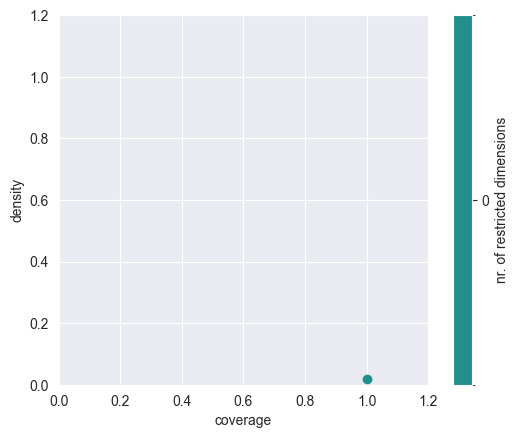

In [57]:
from ema_workbench.analysis import prim
import numpy as np

# Stel een vulnerability-condition in op basis van een relevante outcome
data_rfrtotalcost = outcomes['RfR Total Costs']
# y = data > np.percentile(data, 90)
y_rfrtotalcost = (data_rfrtotalcost <= 369700000).astype(bool)
#y = (data < np.percentile(data, 10)).astype(int)  # of .astype(bool)

# PRIM-analyse
#prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, mode='BINARY')  # expliciet maken

prim_alg_rfrtotalcost = prim.Prim(cleaned_experiments, y_rfrtotalcost, threshold=0.8)
box_rfrtotalcost = prim_alg_rfrtotalcost.find_box()
box_rfrtotalcost.show_tradeoff()
plt.show()


In [58]:
print("Aantal cases of interest:", np.sum(y_rfrtotalcost))

Aantal cases of interest: 500


coverage        1.000000
density         0.018182
id              0.000000
k             500.000000
mass            1.000000
mean            0.018182
n           27500.000000
res_dim         0.000000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []



/Users/evalievanoijen/Downloads/EPA133a-Lab/venv/lib/python3.11/site-packages/ema_workbench/analysis/scenario_discovery_util.py:555: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(top=-0.5, bottom=nr_unc - 0.5)


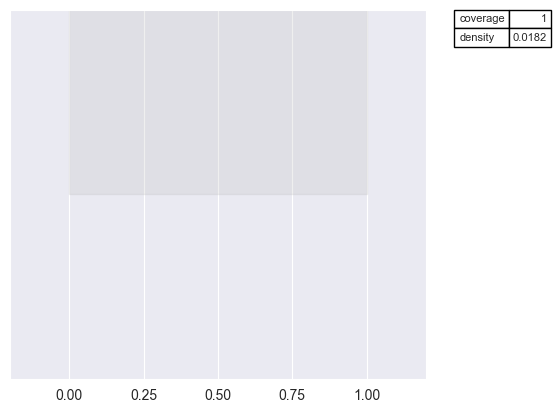

In [59]:
box_rfrtotalcost.inspect()
box_rfrtotalcost.inspect(style='graph')
plt.show()

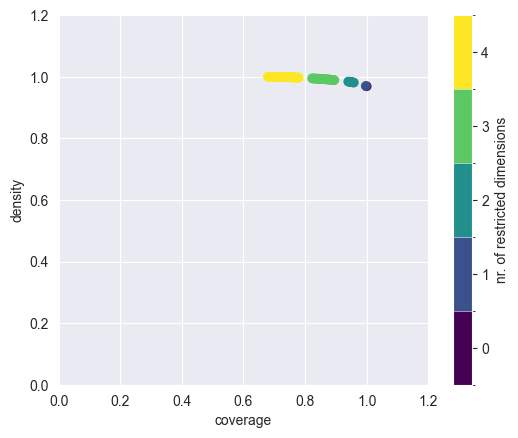

In [60]:
# Stel een vulnerability-condition in op basis van een relevante outcome
data_expanndamage = outcomes['Expected Annual Damage']
# y = data > np.percentile(data, 90)
y_expanndamage = (data_expanndamage <= 369700000).astype(bool)
#y = (data < np.percentile(data, 10)).astype(int)  # of .astype(bool)

# PRIM-analyse
#prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, mode='BINARY')  # expliciet maken

prim_alg_expanndamage = prim.Prim(cleaned_experiments, y_expanndamage, threshold=0.8)
box_expanndamage = prim_alg_expanndamage.find_box()
box_expanndamage.show_tradeoff()
plt.show()

coverage        0.679413
density         1.000000
id             65.000000
k           18105.000000
mass            0.658364
mean            1.000000
n           18105.000000
res_dim         4.000000
Name: 65, dtype: float64

                                                      box 65  \
                                                         min   
A.3_Bmax                                           32.696169   
policy     {575, 577, 578, 579, 580, 581, 584, 585, 586, ...   
A.3_pfail                                           0.050329   
A.2_pfail                                           0.050283   

                                                                            \
                                                         max      qp value   
A.3_Bmax                                          335.026774           NaN   
policy     {575, 577, 578, 579, 580, 581, 584, 585, 586, ...  8.021336e-96   
A.3_pfail                                           0.992298  1.841662e-79   

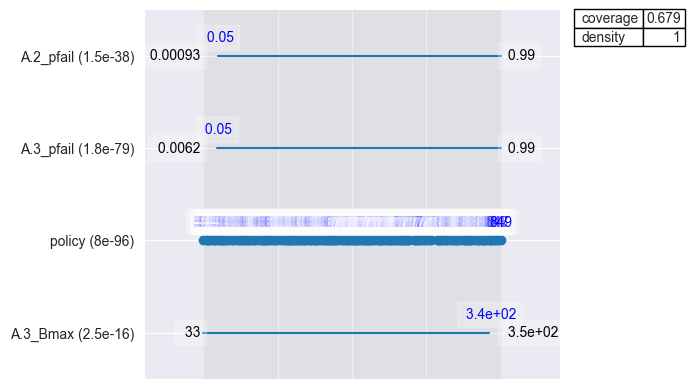

In [61]:
box_expanndamage.inspect()
box_expanndamage.inspect(style='graph')
plt.show()

In [62]:
# Maak een samengestelde outcome "All Costs" aan door de drie relevante outcomes op te tellen
# Zorg ervoor dat deze keys bestaan in je outcomes dictionary
all_costs = (
    outcomes["RfR Total Costs"] +
    outcomes["Dike Investment Costs"] +
    outcomes["Expected Annual Damage"]
)

# Voeg "All Costs" toe aan de outcomes dictionary voor verdere analyse
outcomes["All Costs"] = all_costs


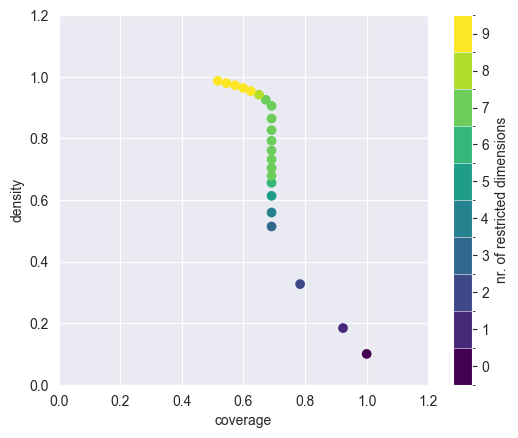

In [63]:
from ema_workbench.analysis import prim
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Vermijd Pandas dtype warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Stel vulnerability condition in
data_allcost = outcomes["All Costs"]
y_allcost = (data_allcost < np.percentile(data_allcost, 10)).astype(int)

# Voer PRIM uit
prim_alg_allcost = prim.Prim(experiments, y_allcost, threshold=0.8)
box_allcost = prim_alg_allcost.find_box()
box_allcost.show_tradeoff()
plt.show()

coverage       0.516727
density        0.986806
id            21.000000
k           1421.000000
mass           0.052364
mean           0.986806
n           1440.000000
res_dim        9.000000
Name: 21, dtype: float64

                                                               box 21  \
                                                                  min   
1_RfR 0                                                           0.0   
1_RfR 2                                                           0.0   
4_RfR 2                                                           0.0   
policy              {575, 576, 577, 578, 579, 580, 581, 582, 583, ...   
A.2_DikeIncrease 0                                                  1   
A.3_DikeIncrease 0                                                  1   
A.1_DikeIncrease 2                                                  1   
A.3_pfail                                                    0.111257   
A.1_pfail                                           

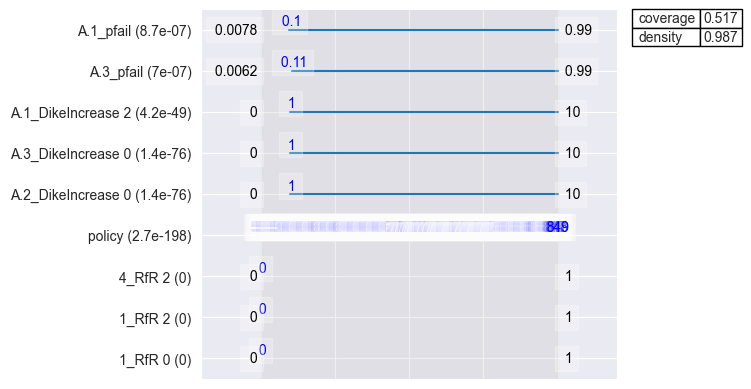

In [64]:
box_allcost.inspect()
box_allcost.inspect(style='graph')
plt.show()

DIT KAN DENK IK WEG. HIER MOET DAN EIGEN TEKST MET UITLEG>

This figure shows the trade-off between coverage, density, and the number of restricted dimensions (i.e., a proxy for interpretability). Each dot corresponds to one candidate box. As an analyst, it is up to you to choose which box you want to inspect in more detail. Here you have to balance the three objectives. There is no hard rule that is used here. Note, however, that a density of lower than 0.5 means that less than half of the cases within the box of interest are of interest. So ideally, you start with higher density boxes. Moreover, you want boxes for which the box limits are statistically significant according to the quasi p-values. This means that the last box for a given number of restricted dimensions is also a good candidate box to inspect (here, for example, the last box with 2 dimensions and the last box with 3 dimensions).

This figure shows in gray the complete interval for each parameter. A blue line is used in the case of RealParameters to show the interval of the box identified by PRIM. For CategoricalParameters, a dot is used instead. The blue numbers give the specific limit. The numbers behind the y-labels indicate the quasi p-values. In the top right-hand corner, you can see the coverage and density of the identified box. So, what do we see in this case. First, both delta and stdev are not significant and should be ignored in the interpretation. This leaves b, q, and some of the policies as the key determinants. So, our top 10% worst performance for reliability occurs if b and q are low and for 6 out of the 10 policies. This covers 56% of the cases of interest, with a precision (i.e. density) of 80%. Now, you would go back to the model and try to understand why you get low reliability if b and q are low.

## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [65]:
from ema_workbench.analysis import dimensional_stacking

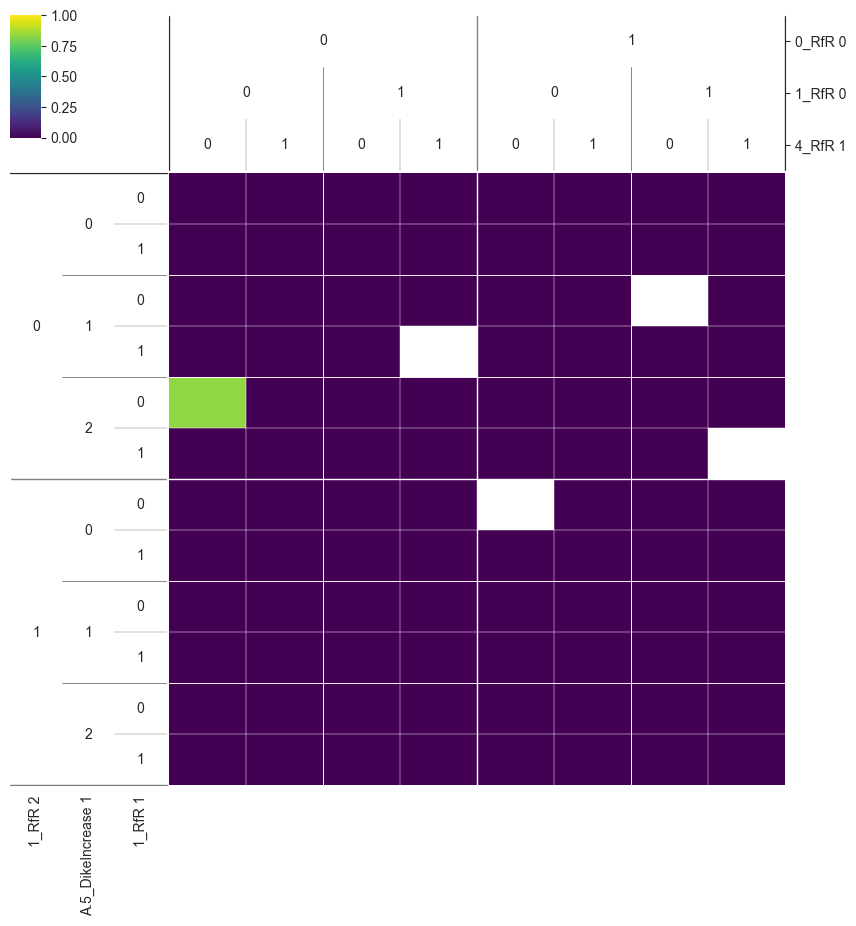

In [67]:
dimensional_stacking.create_pivot_plot(experiments, y_rfrtotalcost)
plt.show()

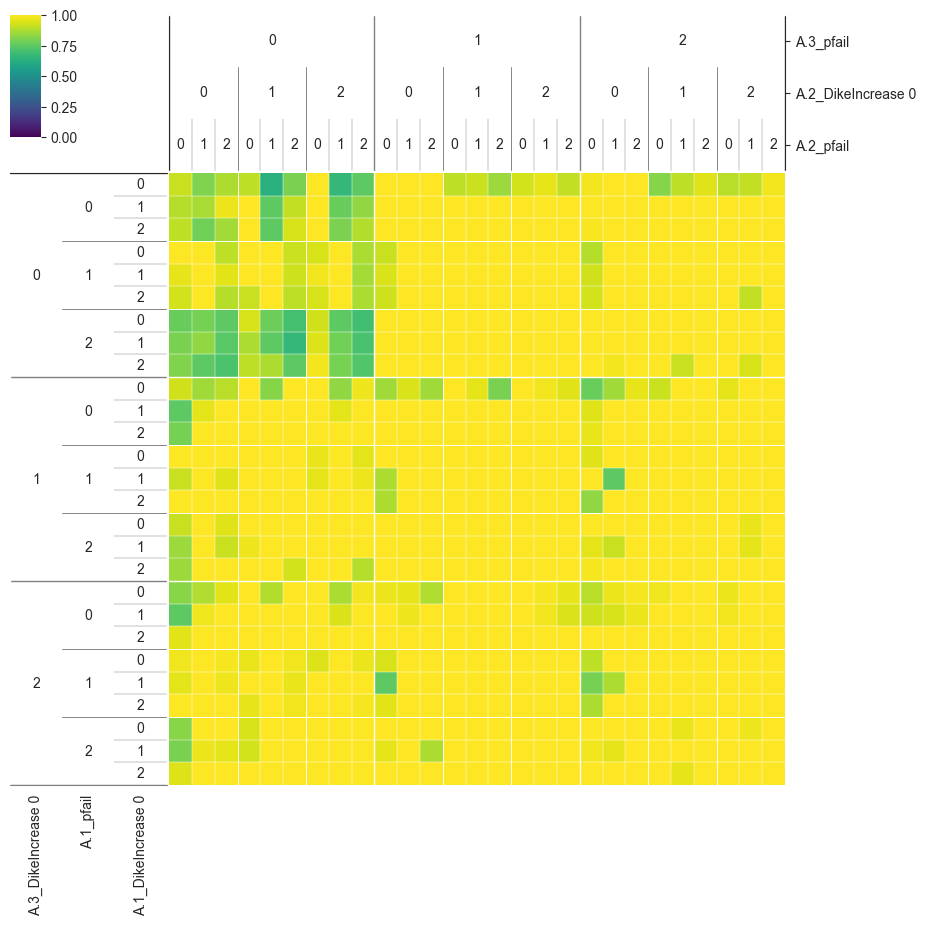

In [68]:
dimensional_stacking.create_pivot_plot(experiments,y_expanndamage)
plt.show()

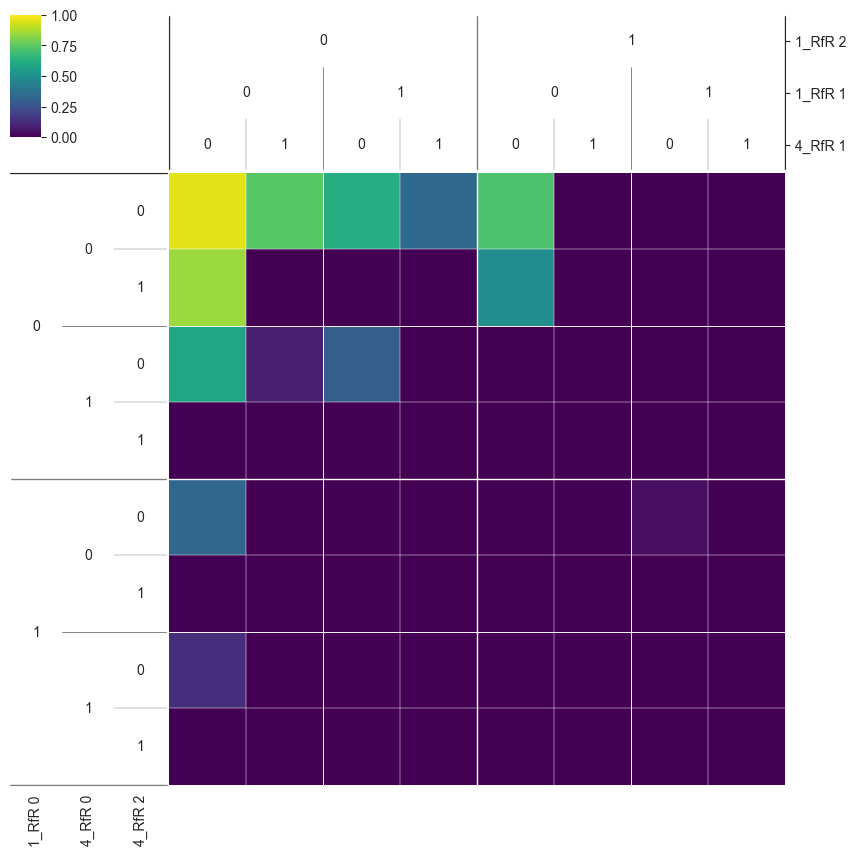

In [69]:
dimensional_stacking.create_pivot_plot(experiments,y_allcost)
plt.show()


DIT KAN WRS WEG. EIGEN TEKST HIER

As you can see, with the additional runs there are at least no white spaces left anymore. This is a good indication that we have a good coverage of the space.

#### Concluding remarks
In this notebook, we have applied several techniques for scenario discovery to the inter temporal version of the lake problem (i.e., the one with 100 decision variables). Both dimensional stacking and PRIM point to the importance of low values for the b and q parameters in driving low reliability. The last, qualitative, step is to go back to the model and offer a structural explanation (remember from system dynamics: structure explains behavior) for this behavior. So why do you get low reliability of b and q are low?